In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('data.csv')
data.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


In [5]:
data = data[['language', 'file_body']]

In [6]:
data.groupby('language').count()

,file_body
language,
C,1078
C++,880
Fortran,745
Go,998
Haskell,1333
Java,987
JavaScript,1104
Julia,637
Kotlin,643


In [7]:
data = data.astype(str)

Let's try use fastAI library to classify langauges

In [8]:
from fastai import *
from fastai.text import *
import string

In [9]:
from fastai.text import Ba

ImportError: cannot import name 'Ba' from 'fastai.text' (/home/mdaniluk/anaconda3/envs/graphs3.7/lib/python3.7/site-packages/fastai/text/__init__.py)

In [12]:
#tokenize letters instead of words
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t):
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass
    
    
itos = [UNK, BOS] + list(string.printable)
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [13]:
def train_valid_split(data, train_ratio):
    mask = np.random.rand(len(data)) < train_ratio
    train_df = data[mask]
    valid_df = data[~mask]
    return train_df, valid_df


train_df, valid_df = train_valid_split(data, train_ratio=0.85)
data = TextClasDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,bs=64)
data.show_batch(10)

text,target
M O D U L E P A R A M E T E R S \t ! A s s o r t e d o d d i t i e s t h a t a s s o r t e d,Fortran
T h i s i s a v e r s i o n o f m i n e s w e e p e r w i t h a g u i . T h e c o d e m i g,Java
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *,Fortran
"f r o m _ _ f u t u r e _ _ i m p o r t p r i n t _ f u n c t i o n , d i v i s i o n \n f r o m v i s u a l i m",Python
e x t e r n c r a t e r u s t c _ s e r i a l i z e ; \n e x t e r n c r a t e t e r m _ p a i n t e r ; \n \n u s e r,Rust
M O D U L E Z E C K E N D O R F A R I T H M E T I C \t ! U s i n g t h e F i b o n a c c i s,Fortran
"s u b P I ( ) { a t a n 2 ( 1 , 1 ) * 4 } # T h e , e r , p i \n s u b S T E",Perl
"r e q u i r e ' s e t ' \n \n m o d u l e T i c T a c T o e \n L I N E S = [ [ 1 , 2 , 3 ] , [ 4 , 5 , 6 ] , [ 7 ,",Ruby
"i m p o r t r a n d o m \n i m p o r t t i m e \n \n d e f d e c r y p t ( F , d ) : \n i f d = = 0",Python
' ' ' \n M i n e s w e e p e r g a m e . \n \n T h e r e i s a n n b y m g r i d t h a t,Python


In [14]:
torch.cuda.set_device(0)

In [15]:
learn = text_classifier_learner(data, AWD_LSTM, pretrained=False, bptt=30)

In [16]:
learn.validate()

[2.9346051, tensor(0.0707)]

In [18]:
learn.fit_one_cycle(1, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 1; 7.94 GiB total capacity; 7.47 GiB already allocated; 18.00 MiB free; 24.02 MiB cached)

Upss, doesn't fit on GPU. Let's try smaller model. We can also try smaller batch size as well.

In [12]:
config = awd_lstm_clas_config.copy()
config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [13]:
config['emb_sz'] = 200
config['n_hid'] = 300
learn = text_classifier_learner(data, AWD_LSTM, pretrained=False, bptt=30, config=config)
learn.fit_one_cycle(1, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.475939,1.255742,0.625453,02:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


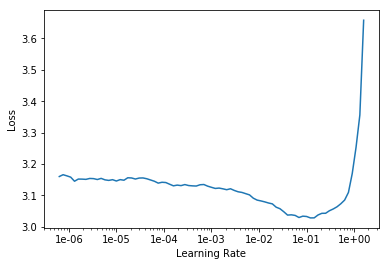

In [14]:
learn = text_classifier_learner(data, AWD_LSTM, pretrained=False, bptt=30, config=config)
learn.lr_find()
learn.recorder.plot()

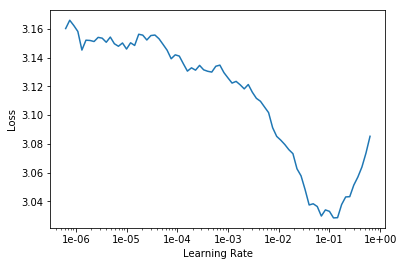

In [15]:
learn.recorder.plot(skip_end=10)

In [16]:
learn.fit_one_cycle(10, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.309458,1.917647,0.443415,02:09
1,1.262030,1.184613,0.651228,02:36
2,0.764954,0.711850,0.790173,02:25
3,0.606961,0.489275,0.858639,02:38
4,0.468751,0.373756,0.896899,02:29
5,0.406569,0.318759,0.908176,02:37
6,0.353734,0.287170,0.920660,02:19
7,0.319616,0.261414,0.928715,02:08
8,0.239237,0.253233,0.927104,02:40
9,0.268586,0.254601,0.929923,02:34


In [17]:
learn.save("awd_lstm_10ep")

In [18]:
data_lm = TextLMDataBunch.from_df(train_df=train_df, valid_df=valid_df, path="", tokenizer=tokenizer, vocab=vocab, bs=64)
data_lm.show_batch(10)
config_lm = awd_lstm_lm_config.copy()
config_lm

idx,text
0,"\n \n v a r c u b e r o o t = x = > M a t h . p o w ( x , 1 / 3 ) ; \n \n \n / / H i g h e r o r d e r"
1,"2 , "" f i v e "" , 6 ) ; \n } ) ( ) ; \n xxbos f u n c t i o n p r i n t A l l ( ) { \n f o r ( v a r i = 0"
2,\n / / b o i l e r p l a t e : g e t l o n g e s t a r r a y o r s t r i n g i n a r r a y \n v a r g e t L o
3,- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - \n \n / / f o l d r (
4,\n i f ( ! n ) { r e t u r n m ; } \n f o r ( j = 0 ; j < = n ; j + + ) {
5,r e t u r n [ ] \n } \n \n r e t u r n A r r a y ( s e l f
6,W 1 B 1 2 W 3 B 2 4 W 1 B 1 4 W ' ) \n ' W W W W W W W W W W W W B W W W W W W W W W W W W B B B W W W W W W
7,i s _ c o m p u t e r _ o n ( s e l f ) : \n r e t u r n T r u e \n \n i f _ _ n a m e _ _ = =
8,\ \n a l l ( d i g i t s . c o u n t ( d i g ) = = a n s w e r . c o u n t ( d i g ) f o
9,"= h . r e p l a c e ( "" 1 "" , "" x "" ) \n h = h . r e p l a c e ( "" 0 "" , "" "" ) \n r e t u r n "" | "" ."


{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [27]:
config_lm['n_hid'] = 300
config_lm['emb_sz'] = 200

In [28]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained=False, config=config_lm)
learn_lm.fit_one_cycle(5, 1e-2)
learn_lm.save_encoder('lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,1.717321,1.646422,0.570755,01:40
1,1.673523,1.539048,0.591093,01:40
2,1.554578,1.443880,0.610872,01:40
3,1.498158,1.363276,0.629708,01:39
4,1.474797,1.335568,0.635608,01:40


In [33]:
TEXT = "for i in range("
N_LETTERS = 40
N_SENTENCES = 5
print("\n".join(learn_lm.predict(TEXT, N_LETTERS, temperature=0.75) for _ in range(N_SENTENCES)))

for i in range( 1 : n ) : 
         p r i n t l n ( " G r a p h i c s   d   i s   w e   a m o u
for i in range( 2 ) 
         s k i p   I d x 
         w h i l e   ( j   = =   0 )   { 
      
for i in range( 1 5 0 ) : 
         r e t u r n   f a l s e 
 
 d e f   g e t _ s u m ( n ) : 

for i in range( 1 ) : 
         f o r   ( i   i n   r a n g e ( n ) )   { 
                 p r
for i in range( 1 ) : 
         f o r   _ ,   s   i n   r a n g e ( c o u n t ) 
              


In [29]:
learn = text_classifier_learner(data, AWD_LSTM, pretrained=False, bptt=30, config=config)
learn.load_encoder('lm_enc');

In [30]:
learn.fit_one_cycle(10, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.605314,0.915430,0.739831,01:27
1,1.097903,0.616390,0.820781,01:36
2,1.025079,0.615091,0.812324,01:40
3,0.979784,0.547778,0.836085,01:42
4,0.950102,0.518097,0.848973,01:31
5,0.896234,0.512531,0.847362,01:38
6,0.895204,0.493430,0.854209,01:36
7,0.901449,0.475952,0.857431,01:34
8,0.778266,0.493601,0.854611,01:31
9,0.883786,0.491847,0.850987,01:24


In [ ]:
learn = text_classifier_learner(data, AWD_LSTM, pretrained=False, config=config)
learn.fit_one_cycle(20, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.647352,2.384703,0.242449,02:19
1,1.676336,1.402630,0.583971,02:32
2,1.116936,0.968991,0.707612,02:16
3,0.810184,0.665915,0.801047,02:10
4,0.640901,0.547463,0.850987,02:22
5,0.553370,0.408875,0.879581,02:27
6,0.434795,0.356309,0.894885,02:36
7,0.362941,0.284388,0.917841,02:18
8,0.359630,0.289242,0.911398,02:34
9,0.294650,0.278406,0.923077,02:18


In [45]:
learn.show_results(rows=20)

text,target,prediction
( ( ) = > { \n ' u s e s t r i c t ' ; \n \n / / p r o b l e m s : : [ [ S t r i n,JavaScript,JavaScript
f u n c t i o n M i n e s w e e p e r \n \n % G a m e p a r a m e t e r s ( s h o u l d b e m o d,MATLAB,MATLAB
"p a c k a g e m a i n \n \n i m p o r t "" f m t "" \n \n / / A s y m e t r y i n t h e a l g o r i t h m s u g g",Go,Go
# i n c l u d e < w i n d o w s . h > \n # i n c l u d e < s t r i n g > \n \n / / - - - - - - - - - - - - - - - - - - - - - - - -,C++,C++
m o d u l e m o d u l e _ r a t i o n a l \n \n i m p l i c i t n o n e \n p r i v a t e \n p u b l i c,Fortran,Fortran
# i n c l u d e < w i n d o w s . h > \n # i n c l u d e < s t r i n g > \n # i n c l u d e < v e c t o r > \n \n / / - - - - -,C++,C++
i m p o r t j a v a . u t i l . * ; \n i m p o r t j a v a . l a n g . M a t h ; \n i m p o r t o r g . a p a c h e . c o m m,Java,Java
"f r o m _ _ f u t u r e _ _ i m p o r t p r i n t _ f u n c t i o n , d i v i s i o n \n f r o m v i s u a l i m",Python,Python
"p a c k a g e m a i n \n \n i m p o r t ( \n "" f m t "" \n "" m a t h "" \n ) \n \n / / T a s k :",Go,Go
i m p o r t j a v a . u t i l . A r r a y s ; \n \n p u b l i c c l a s s L o n g M u l t B i n a r y { \n \n \t / * * \n \t,Java,Java


In [46]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.172821,0.240624,0.939186,01:48
1,0.178432,0.239067,0.937978,01:38
2,0.194384,0.271559,0.935562,01:47
3,0.189172,0.272479,0.936367,01:35
4,0.201126,0.256668,0.938784,01:45
5,0.194926,0.248628,0.944019,01:36
6,0.161343,0.245285,0.942408,01:59
7,0.176553,0.236919,0.942408,01:49
8,0.167063,0.247370,0.942811,01:38
9,0.143010,0.243046,0.942006,01:47


In [48]:
learn.save('awd_1')

In [49]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.151130,0.243958,0.942811,02:25
1,0.157433,0.247759,0.942006,02:23
2,0.155704,0.241916,0.943214,02:08
3,0.141488,0.247702,0.943214,02:11
4,0.147071,0.245206,0.942811,02:16
5,0.148532,0.251116,0.942811,02:29
6,0.191867,0.239840,0.942811,02:22
7,0.164510,0.239209,0.943617,01:59
8,0.152131,0.239882,0.942811,02:31
9,0.120555,0.251414,0.944019,02:33


In [50]:
learn.save('awd_2')

In [54]:
learn.load('awd_1');

In [55]:
learn.fit_one_cycle(20, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.173663,0.239380,0.943214,02:19
1,0.137530,0.245335,0.942811,02:22
2,0.159904,0.255809,0.942006,02:37
3,0.167433,0.267087,0.940395,02:30
4,0.150353,0.250292,0.940395,02:05
5,0.182966,0.268581,0.938381,02:23
6,0.180681,0.267200,0.941603,02:20
7,0.152370,0.257348,0.940797,02:09
8,0.176037,0.258511,0.939992,02:27
9,0.130719,0.271964,0.940395,02:35


In [56]:
learn.save('awd_3')

In [93]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)

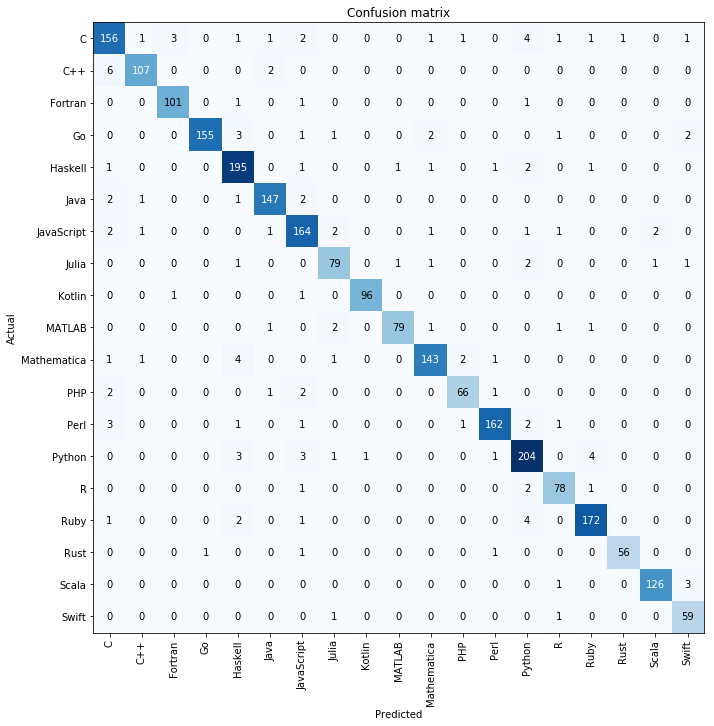

In [94]:
interp.plot_confusion_matrix(figsize=(10,10))

In [95]:
interp.most_confused()[:10]

[('C++', 'C', 6),
 ('C', 'Python', 4),
 ('Mathematica', 'Haskell', 4),
 ('Python', 'Ruby', 4),
 ('Ruby', 'Python', 4),
 ('C', 'Fortran', 3),
 ('Go', 'Haskell', 3),
 ('Perl', 'C', 3),
 ('Python', 'Haskell', 3),
 ('Python', 'JavaScript', 3)]

In [96]:
learn.show_results(rows=20)

text,target,prediction
( ( ) = > { \n ' u s e s t r i c t ' ; \n \n / / p r o b l e m s : : [ [ S t r i n,JavaScript,JavaScript
f u n c t i o n M i n e s w e e p e r \n \n % G a m e p a r a m e t e r s ( s h o u l d b e m o d,MATLAB,MATLAB
"p a c k a g e m a i n \n \n i m p o r t "" f m t "" \n \n / / A s y m e t r y i n t h e a l g o r i t h m s u g g",Go,Go
# i n c l u d e < w i n d o w s . h > \n # i n c l u d e < s t r i n g > \n \n / / - - - - - - - - - - - - - - - - - - - - - - - -,C++,C++
m o d u l e m o d u l e _ r a t i o n a l \n \n i m p l i c i t n o n e \n p r i v a t e \n p u b l i c,Fortran,Fortran
# i n c l u d e < w i n d o w s . h > \n # i n c l u d e < s t r i n g > \n # i n c l u d e < v e c t o r > \n \n / / - - - - -,C++,C++
i m p o r t j a v a . u t i l . * ; \n i m p o r t j a v a . l a n g . M a t h ; \n i m p o r t o r g . a p a c h e . c o m m,Java,Java
"f r o m _ _ f u t u r e _ _ i m p o r t p r i n t _ f u n c t i o n , d i v i s i o n \n f r o m v i s u a l i m",Python,Python
"p a c k a g e m a i n \n \n i m p o r t ( \n "" f m t "" \n "" m a t h "" \n ) \n \n / / T a s k :",Go,Go
i m p o r t j a v a . u t i l . A r r a y s ; \n \n p u b l i c c l a s s L o n g M u l t B i n a r y { \n \n \t / * * \n \t,Java,Java


In [97]:
learn.validate()

[0.25365794, tensor(0.9444)]

In [111]:
interp.show_top_losses(6, max_len=1000)

Text,Prediction,Actual,Loss,Probability
"xxbos s u b p a n c a k e { \n m y @ x = @ _ ; \n f o r m y $ i d x ( 0 . . $ # x - 1 ) { \n m y $ m i n = $ i d x ; \n $ x [ $ m i n ] > $ x [ $ _ ] a n d $ m i n = $ _ f o r $ i d x + 1 . . $ # x ; \n \n n e x t i f $ x [ $ m i n ] = = $ x [ $ i d x ] ; \n \n @ x [ $ m i n . . $ # x ] = r e v e r s e @ x [ $ m i n . . $ # x ] i f $ x [ $ m i n ] ! = $ x [ - 1 ] ; \n @ x [ $ i d x . . $ # x ] = r e v e r s e @ x [ $ i d x . . $ # x ] ; \n } \n @ x ; \n } \n \n m y @ a = m a p ( i n t r a n d ( 1 0 0 ) , 1 . . 1 0 ) ; \n p r i n t "" B e f o r e @ a \ n "" ; \n @ a = p a n c a k e ( @ a ) ; \n p r i n t "" A f t e r @ a \ n "" ; \n",Mathematica,Perl,15.06,0.00
"xxbos u s e M a t h : : F a c t o r : : X S q w / p r i m e _ f a c t o r s / ; \n p r i n t "" $ _ = "" , j o i n ( "" x "" , p r i m e _ f a c t o r s ( $ _ ) ) , "" \ n "" f o r 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 . . 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 ; \n",Mathematica,Perl,14.89,0.00
"xxbos u s e 5 . 0 1 0 _ 0 0 0 ; \n \n p a c k a g e D e l e g a t e : : P r o t o c o l \n u s e M o o s e : : R o l e ; \n # A l l m e t h o d s i n t h e P r o t o c o l i s o p t i o n a l \n # o p t i o n a l ' t h i n g ' ; \n # I f w e w a n t e d t o h a v e a r e q u i r e d m e t h o d , w e w o u l d s t a t e : \n # r e q u i r e s ' r e q u i r e d _ m e t h o d ' ; \n # \n \n p a c k a g e D e l e g a t e : : N o T h i n g ; \n u s e M o o s e ; \n w i t h ' D e l e g a t e : : P r o t o c o l ' ; \n \n p a c k a g e D e l e g a t e ; \n u s e M o o s e ; \n \n # T h e w e c o n f i r m t o D e l e g a t e : : P r o t o c o l \n w i t h ' D e l e g a t e : : P r o t o c o l ' ; \n s u b t h i n g { ' d e l e g a t e i m p l e m e n t a t i o n ' } ; \n \n p a c k a g e D e l e g a t o r ; \n u s e M o o s e ; \n \n h a s d e l e g a t e = > ( \n i s = > ' r w ' , \n d o e s = > ' D e l e g a t e : : P r o t o c o l ' , # M o o s e i n s u r e s t h a t t h e d e l e g a t e c o n f i r m s t o t h e p r o t o c o l . \n p r e d i c a t e = > ' h a s D e l e g a t e ' \n ) ; \n \n s u b o p e r a t i o n { \n \n m y ( $ s e l f ) = @ _ ; \n i f ( $ s e l f - > h a s D e l e g a t e & & $ s e l f - > d e l e g a t e - > c a n ( ' t h i n g ' ) ) { \n r e t u r n $ s e l f - > d e l e g a t e - > t h i n g ( ) . $ p o s t f i x ; # w e a r e k n o w t h a t d e l e g a t e h a s t h i n g . \n } e l s e { \n r e t u r n ' d e f a u l t i m p l e m e n t a t i o n ' ; \n",Mathematica,Perl,14.36,0.00
"xxbos u s e X M L : : S i m p l e ; \n p r i n t X M L o u t ( { r o o t = > { e l e m e n t = > "" S o m e t e x t h e r e "" } } , N o A t t r = > 1 , R o o t N a m e = > "" "" ) ; \n",Mathematica,Perl,12.75,0.00
xxbos f [ ] \n,C,Mathematica,12.58,0.00
"xxbos p a c k a g e m a i n \n \n i m p o r t ( \n "" l o g "" \n \n "" g i t h u b . c o m / v e a n d c o / g o - s d l 2 / s d l "" \n ) \n \n f u n c m a i n ( ) { \n w i n d o w , e r r : = s d l . C r e a t e W i n d o w ( "" R C W i n d o w C r e a t i o n "" , \n s d l . W I N D O W P O S _ U N D E F I N E D , s d l . W I N D O W P O S _ U N D E F I N E D , \n 3 2 0 , 2 0 0 , 0 ) \n i f e r r ! = n i l { \n l o g . F a t a l ( e r r ) \n } \n f o r { \n i f _ , o k : = s d l . W a i t E v e n t ( ) . ( * s d l . Q u i t E v e n t ) ; o k { \n b r e a k \n } \n } \n w i n d o w . D e s t r o y ( ) \n } \n",C++,Go,11.95,0.00


In [102]:
learn.predict('for i in range(10):')

(Category Python,
 tensor(13),
 tensor([1.2868e-06, 2.6628e-08, 8.7530e-05, 3.2697e-07, 2.2394e-09, 3.4782e-10,
         3.3626e-09, 4.7030e-06, 2.1221e-07, 1.3254e-07, 3.5717e-10, 3.0531e-08,
         3.7149e-06, 9.9963e-01, 1.5923e-04, 1.2255e-06, 9.0082e-07, 2.4585e-07,
         1.1100e-04]))

In [104]:
learn.predict('vector<int> arr1 = { 1, 4, 6, 3, 2 };')

(Category C++,
 tensor(1),
 tensor([1.0893e-05, 9.9977e-01, 2.1458e-06, 1.6591e-05, 2.9621e-06, 3.6950e-05,
         5.7423e-05, 3.1936e-05, 7.3178e-09, 1.4078e-05, 2.2803e-06, 5.3852e-06,
         8.0237e-07, 2.3630e-06, 4.0660e-05, 2.8536e-06, 3.6210e-06, 1.4170e-07,
         7.3660e-08]))

In [105]:
learn.predict('import torch')

(Category Python,
 tensor(13),
 tensor([1.4088e-04, 5.3659e-06, 6.1533e-04, 5.0330e-05, 2.1100e-05, 2.9713e-08,
         9.7932e-08, 1.9923e-05, 1.7010e-06, 3.2007e-07, 1.4352e-07, 1.0068e-07,
         2.3545e-07, 9.9911e-01, 1.4466e-06, 7.8217e-07, 5.2896e-06, 1.9794e-05,
         6.6020e-06]))

In [106]:
learn.predict("""
#include <stdio.h>
int main()
{
    int firstNumber, secondNumber, sumOfTwoNumbers;
    
    printf("Enter two integers: ");
    // Two integers entered by user is stored using scanf() function
    scanf("%d %d", &firstNumber, &secondNumber);
    // sum of two numbers in stored in variable sumOfTwoNumbers
    sumOfTwoNumbers = firstNumber + secondNumber;
    // Displays sum      
    printf("%d + %d = %d", firstNumber, secondNumber, sumOfTwoNumbers);
    return 0;
}
""")

(Category C,
 tensor(0),
 tensor([9.9982e-01, 7.1433e-05, 2.5050e-06, 1.0814e-05, 5.3359e-06, 3.1455e-07,
         1.4840e-06, 2.9333e-07, 7.5867e-10, 4.2578e-06, 1.1953e-06, 1.7026e-05,
         2.4368e-07, 4.2896e-05, 2.0816e-05, 7.5559e-07, 2.0479e-08, 1.3871e-08,
         1.2211e-07]))

In [1]:
learn.predict("""
object Main {
  def main(args: Array[String]) {
    try {
      val elems = args map Integer.parseInt
      println("The sum of my arguments is: " + elems.foldRight(0) (_ + _))
    } catch {
      case e: NumberFormatException => 
        println("Usage: scala Main <n1> <n2> ... ")
    }
  }
}
""")

NameError: name 'learn' is not defined

In [113]:
learn.save('model_experiments')